# Problem Statement
---
Book Rent is the largest online and offline book rental chain in India. They provide books of various genres such as thriller, mystery, romance, and science fiction. The company charges a fixed rental fee for a book per month. Lately, the company has been losing its user base. The main reason for this is that users are not able to choose the right books for themselves. The company wants to solve this problem and increase its revenue and profit.

Note: You must perform user based collaborative filtering and item based collaborative filtering.

# Problem Objective
---
- To improve the user experience by personalizing the user needs.
- To create a recommendation engine so that users get
recommendations for books based on the behavior of
similar users. This will ensure that users are renting the
books based on their tastes and traits.

# Prerequisites
---
- Python
- Data preprocessing
- Exploratory data analysis
- Machine learning algorithms
- Recommendation System

# Industry Relevance
---
- Python:It is widely used to implement data analysis and machine
learning.
- Data preprocessing:It includes various steps like treating missing values or removing duplicate values before using the data.
- Exploratory data analysis:It is used to find trends and patterns or to check assumptions by analyzing data with visual tools.
- Machine Learning Algorithm:Various machine learning algorithms are used to predict the outcome based on historical data.
- Recommendation system:It helps the websites to interact with users and enable businesses to maximize their ROI based on the knowledge gathered about each customer's preferences and purchases.

Feel free to check this project in my github repo https://github.com/RajaLairen/Book-Rental-Recommendation-System

# Installed and import the required libraries

In [1]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163702 sha256=a87494e4218218c2ea2956aaa17e26042b2afd9a81c051f0153f0ef0198f845f
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle as pkl
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
from scipy.sparse import coo_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from surprise import Reader,Dataset,SVD,accuracy
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error

In [3]:
# Configs
DATA_PATH='./dataset/'
IMG_PATH='./Plots/'
PKL_PATH='./pkl/'
CSV_PATH='./csv/'

# Create the necessary path
for path in [DATA_PATH,IMG_PATH,PKL_PATH,CSV_PATH]:
  if not os.path.exists(path):
    os.makedirs(path)

# Read the books dataset and explore it

In [4]:
books=pd.read_csv('./dataset/BX-Books.csv',encoding='latin-1')

<ipython-input-4-27f68903905b>:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  books=pd.read_csv('./dataset/BX-Books.csv',encoding='latin-1')


In [5]:
books.shape

(271379, 5)

In [6]:
books.dtypes

isbn                   object
book_title             object
book_author            object
year_of_publication    object
publisher              object
dtype: object

In [7]:
books.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


# Clean up NaN value

In [8]:
books.isna().sum()

isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
dtype: int64

In [9]:
# as there are 271379 rows and only 1 or 2 of them are missing so we can drop that rows
books.dropna(inplace=True)

In [10]:
books.isna().any().any()

False

# Read the data where ratings are given by users

In [11]:
ratings=pd.read_csv('./dataset/BX-Book-Ratings.csv',encoding='latin-1')

In [12]:
ratings.head()

,user_id,isbn,rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6


In [13]:
ratings.shape

(1048575, 3)

In [14]:
ratings.isna().any().any()

False

# Take a quick look at the number of unique users and books

In [15]:
print("Number of unique book:",len(ratings['isbn'].unique()))
print("Number of unique users:",len(ratings['user_id'].unique()))

Number of unique book: 322102
Number of unique users: 95513


# Reading the users data

In [16]:
users=pd.read_csv('./dataset/BX-Users.csv',encoding='latin-1')

<ipython-input-16-f194c83acb95>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  users=pd.read_csv('./dataset/BX-Users.csv',encoding='latin-1')


In [17]:
users.head()

,user_id,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [18]:
users.shape

(278859, 3)

In [19]:
users.isna().sum()

user_id          0
Location         1
Age         110763
dtype: int64

In [20]:
users.describe()

,Age
count,168096.000000
mean,34.751434
std,14.428097
min,0.000000
25%,24.000000
50%,32.000000
75%,44.000000
max,244.000000


## We have to remove the person having age greater than 100 as it have low change for the person to read book at this age

In [21]:
users=users.loc[users['Age']<=100]

In [22]:
users

,user_id,Location,Age
1,2,"stockton, california, usa",18.0
3,4,"porto, v.n.gaia, portugal",17.0
5,6,"santa monica, california, usa",61.0
9,10,"albacete, wisconsin, spain",26.0
10,11,"melbourne, victoria, australia",14.0
...,...,...,...
278849,278849,"georgetown, ontario, canada",23.0
278851,278851,"dallas, texas, usa",33.0
278852,278852,"brisbane, queensland, australia",32.0
278853,278853,"stranraer, n/a, united kingdom",17.0


In [23]:
users.isna().sum()

user_id     0
Location    0
Age         0
dtype: int64

In [24]:
books

,isbn,book_title,book_author,year_of_publication,publisher
0,195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,2005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,60973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company
...,...,...,...,...,...
271374,440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm)
271375,525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books
271376,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco
271377,192126040,Republic (World's Classics),Plato,1996,Oxford University Press


In [25]:
ratings

,user_id,isbn,rating
0,276725,034545104X,0
1,276726,155061224,5
2,276727,446520802,0
3,276729,052165615X,3
4,276729,521795028,6
...,...,...,...
1048570,250764,451410777,0
1048571,250764,452264464,8
1048572,250764,048623715X,0
1048573,250764,486256588,0


In [26]:
users

,user_id,Location,Age
1,2,"stockton, california, usa",18.0
3,4,"porto, v.n.gaia, portugal",17.0
5,6,"santa monica, california, usa",61.0
9,10,"albacete, wisconsin, spain",26.0
10,11,"melbourne, victoria, australia",14.0
...,...,...,...
278849,278849,"georgetown, ontario, canada",23.0
278851,278851,"dallas, texas, usa",33.0
278852,278852,"brisbane, queensland, australia",32.0
278853,278853,"stranraer, n/a, united kingdom",17.0


In [27]:
master_df=pd.merge(users,ratings,on='user_id',how='inner')

In [28]:
master_df=pd.merge(master_df,books,on='isbn',how='inner')

In [29]:
master_df.head()

,user_id,Location,Age,isbn,rating,book_title,book_author,year_of_publication,publisher
0,2,"stockton, california, usa",18.0,195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,10,"albacete, wisconsin, spain",26.0,1841721522,0,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd
2,3675,"barcelona, catalunya, spain",24.0,1841721522,0,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd
3,6366,"madrid, madrid, spain",20.0,1841721522,7,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd
4,13872,"barcelona, catalunya, spain",17.0,1841721522,0,New Vegetarian: Bold and Beautiful Recipes for...,Celia Brooks Brown,2001,Ryland Peters &amp; Small Ltd


# Fixing the year of publication,author,title and publisher. As there are some book whose title contain the year of publication like that

In [30]:
master_df['year_of_publication'].unique()

array(['2002', '2001', '2003', '1998', '1979', '1997', '1999', '2000',
       '1986', '1991', '1995', '1978', '1980', '1994', '1983', '1952',
       '1988', '1987', '1996', '2004', '1990', '1992', '0', '1993',
       '1989', '1984', '1981', '1968', '1982', '1959', '1946', '1985',
       '1974', '1958', '1976', '1971', '1975', '1965', '1977', '1972',
       '1973', '1970', '1960', '1962', '1954', '1966', '1920', '1967',
       '1942', '1955', '1951', '1969', '1948', '1964', '1950', '2005',
       '1961', '1943', '1953', '1957', '1956', '\\"Freedom Song\\""',
       '1941', '1937', '1940', 'John Peterman', '1963', '1930', '1923',
       '1945', '1947', '1936', '2011', '1925', '2020', '1939', '1938',
       '2030', '1911', '1949', 'Frank Muir', '1932', '1929', '1927',
       '1944', '1933', 'Isadora Duncan', '1922', '1926', '1897', '2050',
       '1902', 'Karen T. Whittenburg', '1924', '1921', 'ROBERT A. WILSON',
       '1900', '2038', '2010', '1928', '2006', 'Stan Berenstain', '2026',
  

In [31]:
year_of_publications=master_df['year_of_publication'].unique()

In [32]:
# Get the wrong year of publication
publications=[]
for publication in year_of_publications:
  try:
    # Try to typecaset into int if error occur append it to the publications
    int(publication)
  except Exception:
    publications.append(publication)

In [33]:
publications

['\\"Freedom Song\\""',
 'John Peterman',
 'Frank Muir',
 'Isadora Duncan',
 'Karen T. Whittenburg',
 'ROBERT A. WILSON',
 'Stan Berenstain',
 'George H. Scherr',
 'Francine Pascal',
 'Gallimard',
 'Luella Hill',
 'Salvador de Madariaga',
 'K.C. Constantine',
 'Bart Rulon',
 'Alan Rich',
 'DK Publishing Inc']

In [34]:
# Get the index for wrong year of publication
indx=[]
for publication in publications:
  indx.append(master_df[master_df['year_of_publication']==publication].index.values)
indx
# indx=np.concatenate(indx)

[array([126485, 126486]),
 array([146579, 146580, 146581, 146582, 146583]),
 array([354452]),
 array([403378]),
 array([458359]),
 array([466710, 466711, 466712, 466713, 466714, 466715, 466716]),
 array([527053, 527054, 527055]),
 array([535321]),
 array([540295]),
 array([595971]),
 array([635941]),
 array([653857]),
 array([655016]),
 array([658070]),
 array([658530]),
 array([666323])]

In [35]:
book_data=[
{
    'title':"Three Novels: 'A Strange and Sublime Address', ' Afternoon Raag', 'Freedom Song",
    'author':'Amit Chaudhuri',
    'year_of_publication':2001,
    'publisher':'Picador'
},
{
    'title':'Peterman Rides Again: Adventures Continue with the Real "J.Peterman" Through Life &amp the Catalog Business',
    'author':'John Peterman',
    'year_of_publication':2000,
    'publisher':'Prentice Hall Press'
},
{
    'title':'Upon my word!: More stories from "My word!" a panel game devised by Edward J. Mason & Tony Shryane',
    'author':'Frank Muir',
    'year_of_publication':1974,
    'publisher':'Eyre Methuen'
},
{
    'title':'Your Isadora: The Love Story of Isadora Duncan & Gordon Craig',
    'author':'Isadora Duncan',
    'year_of_publication':1976,
    'publisher':'Pub Center Cultural Resources'
},
{
    'title':'Please Say "I Do" (Three Weddings & A Hurricane) (Harlequin American Romance)',
    'author':'Karen T. Whittenburg',
    'year_of_publication':1997,
    'publisher':'Harlequin'
},
{
    'title':"Schrodinger's Cat Trilogy: 'The Universe Next Door', 'The Trick Top Hat', & 'The Homing Pigeons'",
    'author':'ROBERT A. WILSON',
    'year_of_publication':1988,
    'publisher':'Dell'
},
{
    'title':'‘C’ is for Clown: A Circus of ‘C’ Words (Bright and Early Books)',
    'author':'Stan Berenstain',
    'year_of_publication':1972,
    'publisher':'HarperCollinsChildren’sBooks'
},
{
    'title':'The Best of the Journal of Irreproducible Results:Improbable Investigations & Unfounded Findings',
    'author':'George H. Scherr',
    'year_of_publication':1989,
    'publisher':'Workman Publishing'
},
{
    'title':'R for Revenge: Written by Kate William book_author Created by Francine Pascal (Sweet Valley High Super Thriller, No 24)',
    'author':'Francine Pascal',
    'year_of_publication':1997,
    'publisher':'Skylark'
},
{
    'title':'Peuple du ciel, suivi de "Les Bergers"',
    'author':'Jean-Marie Gustave Le Clézio',
    'year_of_publication':2003,
    'publisher':'Gallimard'
},
{
    'title':'Solid as a rock "I" stand: Inspirational poetry & short stories',
    'author':'Luella Hill',
    'year_of_publication':1998,
     'publisher':'Straight fwrom the Heart Associates'
},
{
    'title':'Guía del lector del "Quijote": Ensayo psicológico sobre el "Quijote"',
    'author':'Salvador de Madariaga',
    'year_of_publication':1976,
    'publisher':'Espasa Calpe'
},
{
    'title':'The Double Detective: "The Blank Page" & "A Fix Like This" (Crime Club)',
    'author':'K.C. Constantine',
    'year_of_publication':1990,
    'publisher':'Hodder & Stoughton General Division'
},
{
    'title':'Water and Skies (Artist"s Photo Reference S.)',
    'author':'Bart Rulo',
    'year_of_publication':2002,
    'publisher':'North Light Books'
},
{
    'title':'Ludwig van Beethoven: Play by Play/Symphony No.3 "Eroica"; The "Egmont" Overture',
    'author':'Alan Rich',
    'year_of_publication':1995,
    'publisher':'Harpercollins'
},
{
    'title':'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)',
    'author':'James Buckley',
    'year_of_publication':2000,
    'publisher':'DK Publishing Inc'
}
]

In [36]:
# Refer the link.
#https://www.amazon.in/Peterman-Rides-Again-John/dp/0735201994/ref=sr_1_1?keywords=Peterman+Rides+Again%3A+Adventures+Continue+with+the+Real+%22J.+Peterman%22+Through+Life+%26+the+Catalog+Business&nsdOptOutParam=true&sr=8-1
# https://www.amazon.in/Three-Novels-Strange-Sublime-Afternoon/dp/0330482750/ref=sr_1_1?keywords=Three+Novels%3A+%5CA+Strange+and+Sublime+Address%5C%22&sr=8-1
# https://www.amazon.in/Upon-word-stories-devised-Shryane/dp/0413326608/ref=sr_1_1?keywords=Upon+my+word%21%3A+More+stories+from+%5CMy+word%21%5C%22+a+panel+game+devised+by+Edward+J.+Mason+%26amp&nsdOptOutParam=true&sr=8-1
# https://www.amazon.in/Schrodingers-Cat-Trilogy-Universe-Pigeons/dp/0440500702/ref=sr_1_1?keywords=Schrodinger%27s+Cat+Trilogy+%3A+%5CThe+Universe+Next+Door%5C%22%2C+%5C%22The+Trick+Top+Hat%5C%22%2C+%26amp&nsdOptOutParam=true&sr=8-1
# https://www.amazon.in/Weddings-Hurricane-Harlequin-American-Romance/dp/0373166982/ref=sr_1_1?keywords=Please+Say+%22I+Do%22+%28Three+Weddings+%26+A+Hurricane%29&nsdOptOutParam=true&sr=8-1
# https://www.amazon.in/Best-Journal-Irreproducable-Results/dp/0894805959
# https://www.amazon.com/Solid-rock-stand-Inspirational-stories/dp/096401811X

In [37]:
for idx,bookdt in zip(indx,book_data):
  for i in range(len(idx)):
    master_df.loc[idx[i],'book_title']=bookdt['title']
    master_df.loc[idx[i],'book_author']=bookdt['author']
    master_df.loc[idx[i],'year_of_publication']=bookdt['year_of_publication']
    master_df.loc[idx[i],'publisher']=bookdt['publisher']

In [38]:
master_df['year_of_publication'].unique()

array(['2002', '2001', '2003', '1998', '1979', '1997', '1999', '2000',
       '1986', '1991', '1995', '1978', '1980', '1994', '1983', '1952',
       '1988', '1987', '1996', '2004', '1990', '1992', '0', '1993',
       '1989', '1984', '1981', '1968', '1982', '1959', '1946', '1985',
       '1974', '1958', '1976', '1971', '1975', '1965', '1977', '1972',
       '1973', '1970', '1960', '1962', '1954', '1966', '1920', '1967',
       '1942', '1955', '1951', '1969', '1948', '1964', '1950', '2005',
       '1961', '1943', '1953', '1957', '1956', 2001, '1941', '1937',
       '1940', 2000, '1963', '1930', '1923', '1945', '1947', '1936',
       '2011', '1925', '2020', '1939', '1938', '2030', '1911', '1949',
       1974, '1932', '1929', '1927', '1944', '1933', 1976, '1922', '1926',
       '1897', '2050', '1902', 1997, '1924', '1921', 1988, '1900', '2038',
       '2010', '1928', '2006', 1972, '2026', 1989, '2021', '1931', '1378',
       '1908', '1910', 2003, '1901', '1909', '2008', '1376', '2037', 199

# Convert ISBN to numeric numbers in the correct order
# Convert both user_id and ISBN to the ordered list i.e., from 0...n

In [39]:
master_df.sort_values('isbn',inplace=True)

In [40]:
isbn=master_df['isbn'].unique()
isbn

array(['000104799X', '000123207X', '000160418X', ..., 'B00029DGGO',
       'B0002JV9PY', 'B0002K6K8O'], dtype=object)

In [41]:
isbn_dict={}
for indx,val in enumerate(isbn):
    isbn_dict[val]=indx

In [42]:
master_df['isbn']=[isbn_dict[x] for x in master_df['isbn']]

In [43]:
master_df.head()

,user_id,Location,Age,isbn,rating,book_title,book_author,year_of_publication,publisher
353810,28204,"south ohio, nova scotia, canada",61.0,0,7,Monk's-hood,Ellis Peters,1994,HarperCollins Publishers
353811,166596,"greenwood, british columbia, canada",57.0,0,8,Monk's-hood,Ellis Peters,1994,HarperCollins Publishers
646725,198711,"little canada, minnesota, usa",62.0,1,0,Paddington's Birthday Party,Michael Bond,1942,HarperCollins Publishers
225024,10067,"watton, norfolk, england",61.0,2,7,The Clue in the Crumbling Wall,Carolyn Keene,1984,HarperCollins Publishers
660073,215677,"matlock, england, united kingdom",44.0,3,0,Little Grey Rabbit makes lace (The Little Grey...,Alison Uttley,1986,Collins


# Do the same for user_id. Convert it into numeric order
# Convert both user_id and ISBN to the ordered list i.e., from 0...n

In [44]:
user_id=master_df['user_id'].unique()

In [45]:
user_dict={}
for indx,data in enumerate(user_id):
    user_dict[data]=indx

In [46]:
master_df['user_id']=[user_dict[x] for x in master_df['user_id']]

In [47]:
master_df.head()

,user_id,Location,Age,isbn,rating,book_title,book_author,year_of_publication,publisher
353810,0,"south ohio, nova scotia, canada",61.0,0,7,Monk's-hood,Ellis Peters,1994,HarperCollins Publishers
353811,1,"greenwood, british columbia, canada",57.0,0,8,Monk's-hood,Ellis Peters,1994,HarperCollins Publishers
646725,2,"little canada, minnesota, usa",62.0,1,0,Paddington's Birthday Party,Michael Bond,1942,HarperCollins Publishers
225024,3,"watton, norfolk, england",61.0,2,7,The Clue in the Crumbling Wall,Carolyn Keene,1984,HarperCollins Publishers
660073,4,"matlock, england, united kingdom",44.0,3,0,Little Grey Rabbit makes lace (The Little Grey...,Alison Uttley,1986,Collins


# Re-index columns to build matrix later on

In [48]:
master_df.index=range(master_df.shape[0])

In [49]:
master_df.head()

,user_id,Location,Age,isbn,rating,book_title,book_author,year_of_publication,publisher
0,0,"south ohio, nova scotia, canada",61.0,0,7,Monk's-hood,Ellis Peters,1994,HarperCollins Publishers
1,1,"greenwood, british columbia, canada",57.0,0,8,Monk's-hood,Ellis Peters,1994,HarperCollins Publishers
2,2,"little canada, minnesota, usa",62.0,1,0,Paddington's Birthday Party,Michael Bond,1942,HarperCollins Publishers
3,3,"watton, norfolk, england",61.0,2,7,The Clue in the Crumbling Wall,Carolyn Keene,1984,HarperCollins Publishers
4,4,"matlock, england, united kingdom",44.0,3,0,Little Grey Rabbit makes lace (The Little Grey...,Alison Uttley,1986,Collins


In [50]:
# Fixing the age column
master_df['Age'].unique()

array([ 61.,  57.,  62.,  44.,  43.,  27.,  55.,  42.,  40.,  25.,  23.,
        22.,  37.,  51.,  32.,  29.,  56.,  30.,  54.,  38.,  49.,  46.,
        31.,  48.,  18.,  58.,  34.,  28.,  33.,  39.,  17.,  14.,  52.,
        24.,  47.,  77.,  26.,  20.,  36.,  35.,  45.,  21.,  59.,  41.,
        50.,  60.,  63.,  65.,  81.,  15.,  66.,  71.,  53.,  69.,   1.,
        19.,   0.,  73.,  64.,  72.,  67.,  68.,  78.,  12.,  11.,  13.,
        16.,   8.,  90.,   2.,  70.,   3.,  97.,  83.,  82.,  75.,  76.,
       100.,   9.,   5.,   4.,  80.,   7.,  10.,  85.,  74.,  79.,   6.,
        84.,  99.,  93.,  92.,  95.,  89.,  94.,  96.,  86.])

Which are the top Author with number of books ?

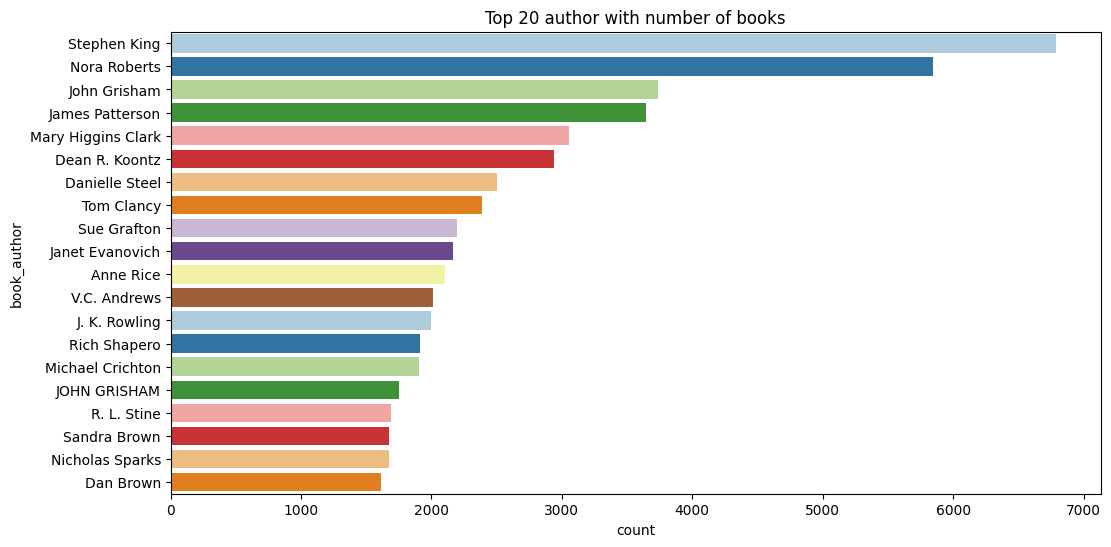

In [51]:
plt.figure(figsize=(12,6))
sns.countplot(y="book_author",palette = 'Paired', data=master_df,order=master_df['book_author'].value_counts().index[0:20])
plt.title("Top 20 author with number of books")
plt.savefig(IMG_PATH+'Top 20 author with number of books')

**Which are top publishers with published books ?**

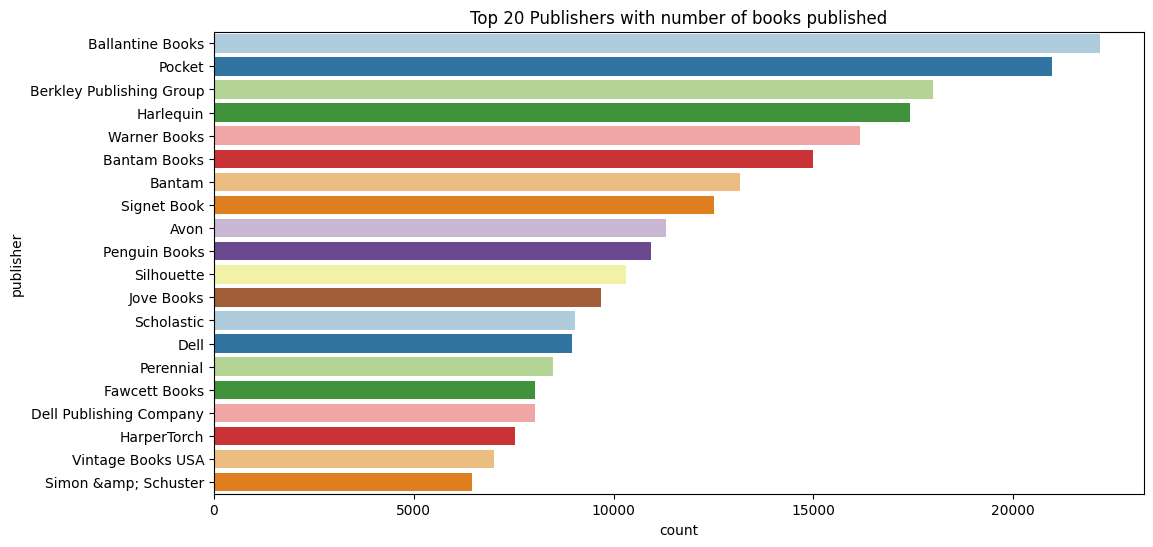

In [52]:
plt.figure(figsize=(12,6))
sns.countplot(y="publisher",palette = 'Paired', data=master_df,order=master_df['publisher'].value_counts().index[0:20])
plt.title("Top 20 Publishers with number of books published")
plt.savefig(IMG_PATH+'Top 20 Publishers with number of books published')

**Number of Books published in yearly?**

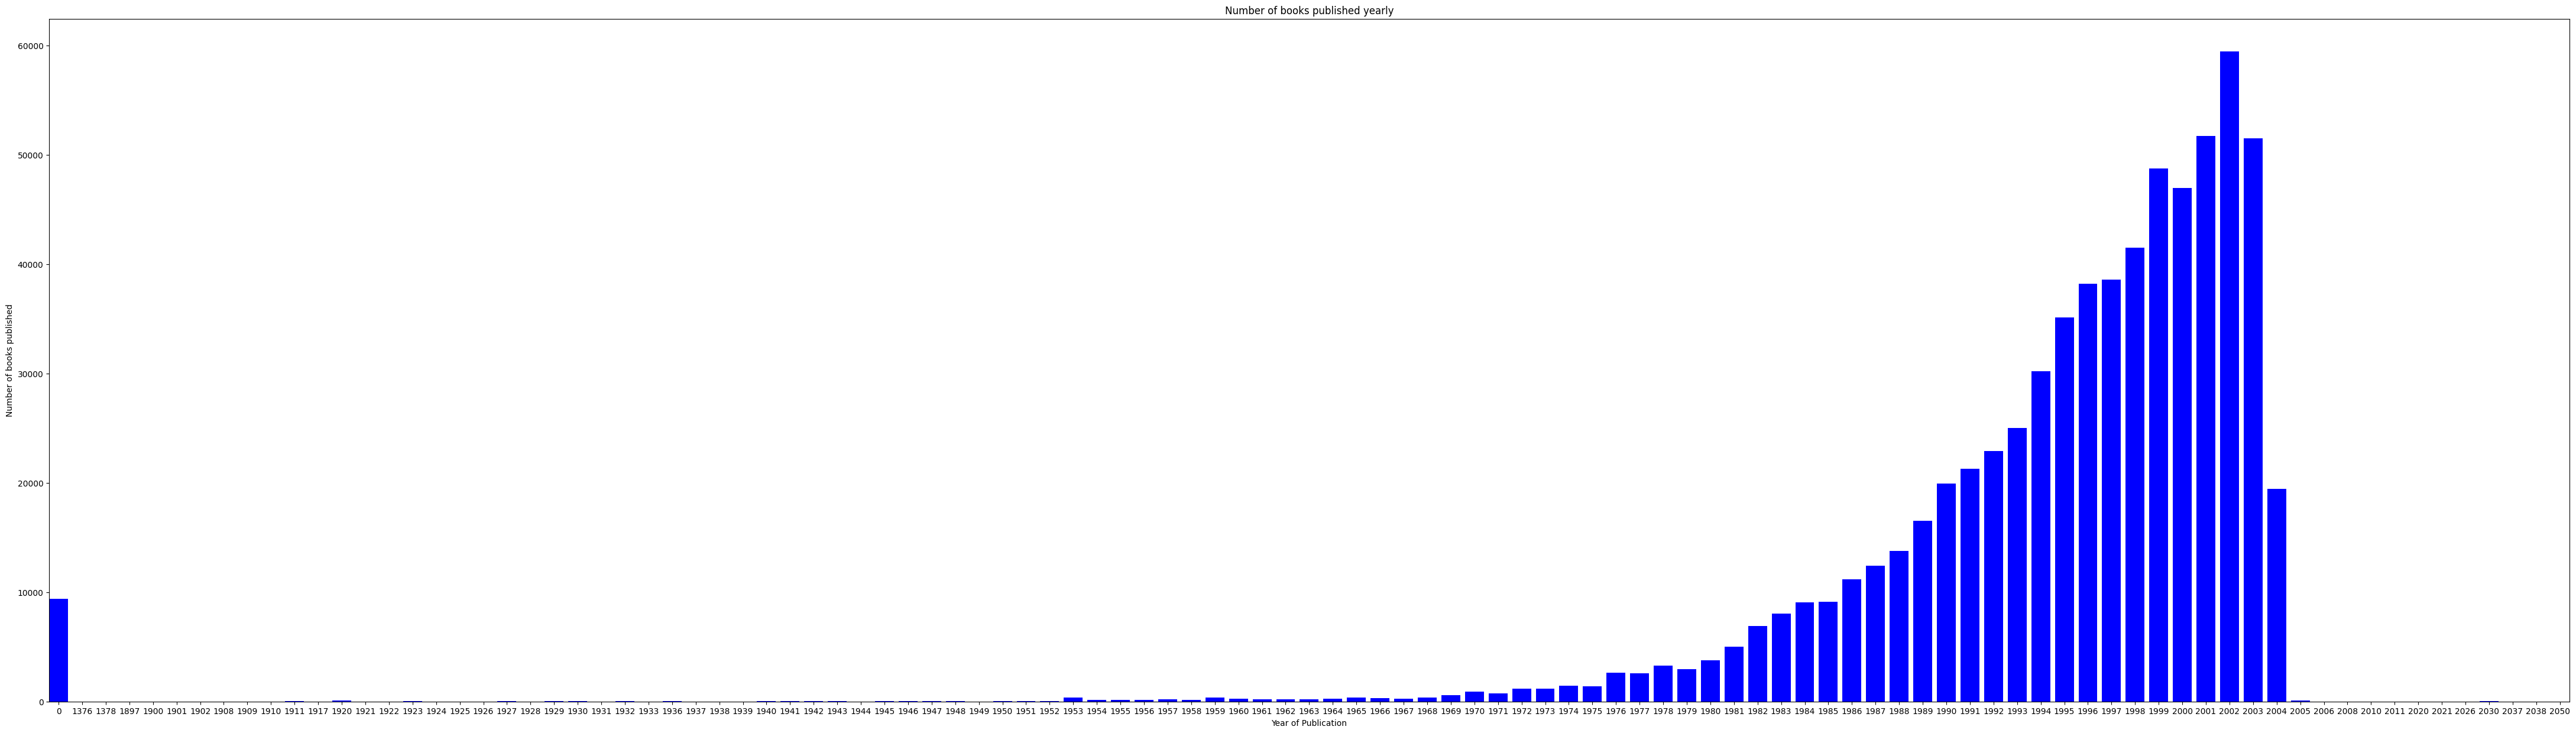

In [53]:
publications = {}
for year in master_df['year_of_publication']:
    if str(year) not in publications:
        publications[str(year)] = 0
    publications[str(year)] +=1

publications = {k:v for k, v in sorted(publications.items())}

fig = plt.figure(figsize =(55, 15))
plt.bar(list(publications.keys()),list(publications.values()), color = 'blue')
plt.ylabel("Number of books published")
plt.xlabel("Year of Publication")
plt.title("Number of books published yearly")
plt.margins(x = 0)
plt.savefig(IMG_PATH+'Number of books published yearly')
plt.show()

In [54]:
master_df['year_of_publication']=master_df['year_of_publication'].astype(int)

In [55]:
# Checking for 0's or NaNs in Year of Publication
zero_year = master_df[master_df.year_of_publication == 0].year_of_publication.count()
nan_year = master_df.year_of_publication.isnull().sum()

print(f'There are {zero_year} entries as \'0\', and {nan_year} NaN entries in the Year of Publication field')


# Replace all years of zero with NaN
master_df.year_of_publication.replace(0, np.nan, inplace=True)

There are 9406 entries as '0', and 0 NaN entries in the Year of Publication field


In [56]:
master_df.isna().sum()/master_df.shape[0]*100

user_id                0.000000
Location               0.000000
Age                    0.000000
isbn                   0.000000
rating                 0.000000
book_title             0.000000
book_author            0.000000
year_of_publication    1.384595
publisher              0.000000
dtype: float64

In [57]:
# We can safely drop the the nan for year_of_publication as 1% of the year_of_publication has nan value.
master_df.dropna(inplace=True)

In [58]:
master_df.isna().sum()

user_id                0
Location               0
Age                    0
isbn                   0
rating                 0
book_title             0
book_author            0
year_of_publication    0
publisher              0
dtype: int64

**Data distribution for year of publication for count greater than 5**

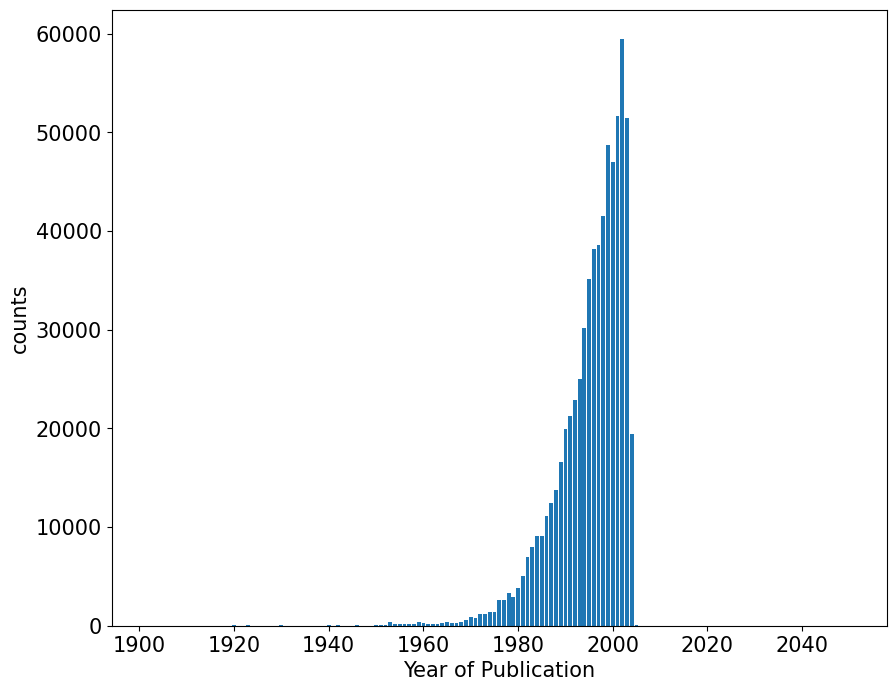

In [59]:
year = master_df.year_of_publication.value_counts().sort_index()
year = year.where(year>5)
plt.figure(figsize=(10, 8))
plt.rcParams.update({'font.size': 15})
plt.bar(year.index, year.values)
plt.xlabel('Year of Publication')
plt.ylabel('counts')
plt.savefig(IMG_PATH+'Year of Publication')
plt.show()

## What are top 20 books as per number of ratings ?

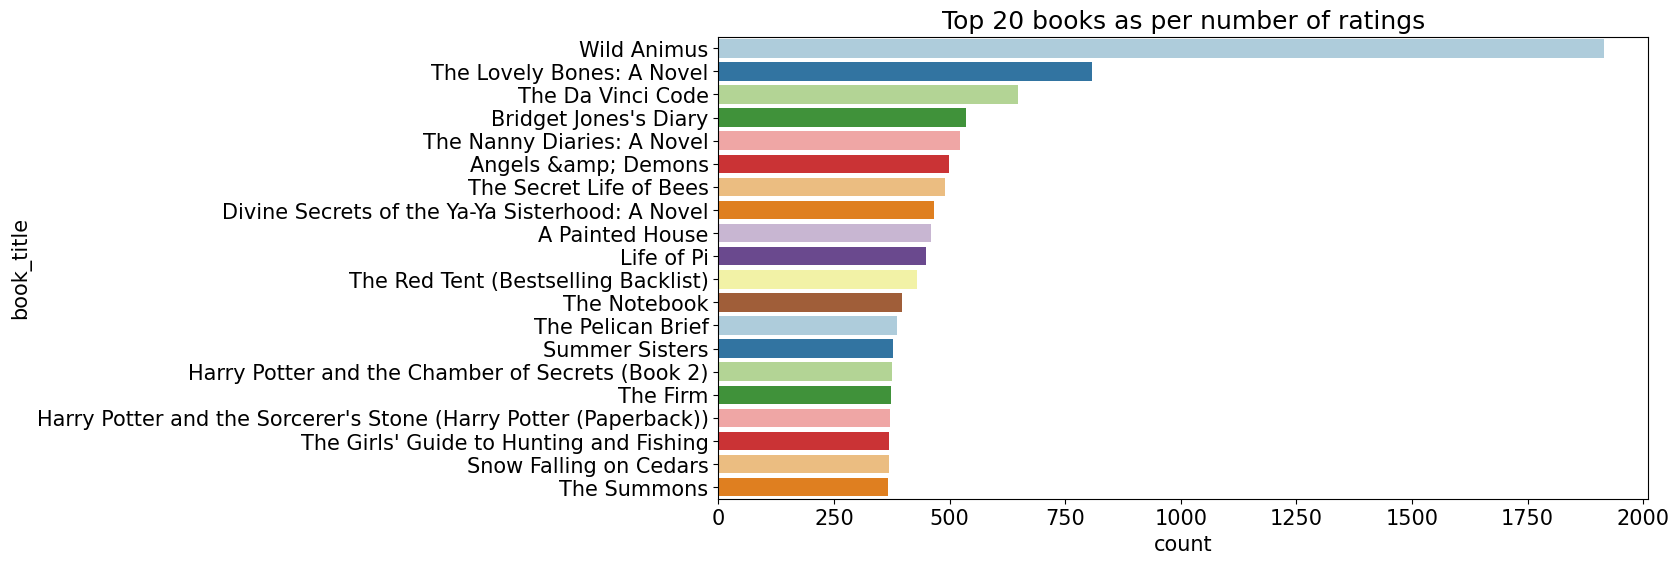

In [60]:
plt.figure(figsize=(12,6))
sns.countplot(y="book_title",palette = 'Paired',data= master_df, order=master_df['book_title'].value_counts().index[0:20])
plt.title("Top 20 books as per number of ratings")
plt.savefig(IMG_PATH+'Top 20 books as per number of ratings')

In [61]:
master_df.to_csv(CSV_PATH+'master_df.csv')

In [62]:
new_book_df=master_df[master_df['rating']!=0]

# Recommender System

In [63]:
rating_explicit_df=new_book_df[['user_id','isbn','rating']]
rating_explicit_df.to_csv(CSV_PATH+'rating_explicit.csv')

# Split your data into two sets (training and testing)

In [64]:
from sklearn import model_selection
train_data, test_data = model_selection.train_test_split(new_book_df, test_size=0.20)

In [65]:
train_data.to_csv(CSV_PATH+'train_data.csv')
test_data.to_csv(CSV_PATH+'test_data.csv')

In [66]:
print(f'Training set lengths: {len(train_data)}')
print(f'Testing set lengths: {len(test_data)}')
print(f'Test set is {(len(test_data)/(len(train_data)+len(test_data))*100):.0f}% of the full dataset.')

Training set lengths: 192660
Testing set lengths: 48165
Test set is 20% of the full dataset.


In [67]:
# Get int mapping for user_id in train dataset
u_unique_train = train_data.user_id.unique()
train_data_user2idx = {o:i for i, o in enumerate(u_unique_train)}

# Get int mapping for isbn in train dataset
i_unique_train = train_data.isbn.unique()
train_data_book2idx = {o:i for i, o in enumerate(i_unique_train)}

In [68]:
# Get int mapping for user_id in test dataset
u_unique_test = test_data.user_id.unique()
test_data_user2idx = {o:i for i, o in enumerate(u_unique_test)}

# Get int mapping for isbn in test dataset
i_unique_test = test_data.isbn.unique()
test_data_book2idx = {o:i for i, o in enumerate(i_unique_test)}

In [69]:
# training set
train_data['u_unique'] = train_data['user_id'].map(train_data_user2idx)
train_data['i_unique'] = train_data['isbn'].map(train_data_book2idx)

# testing set
test_data['u_unique'] = test_data['user_id'].map(test_data_user2idx)
test_data['i_unique'] = test_data['isbn'].map(test_data_book2idx)

# Convert back to three feature of dataframe
train_data = train_data[['u_unique', 'i_unique', 'rating']]
test_data = test_data[['u_unique', 'i_unique', 'rating']]

In [70]:
train_data.sample(5)

,u_unique,i_unique,rating
179780,14503,56911,8
21534,2069,703,7
455050,551,1627,8
114910,774,68135,5
658545,477,30427,7


In [71]:
test_data.sample(5)

,u_unique,i_unique,rating
62411,8486,15824,6
324013,139,24453,10
480142,75,79,7
611433,3913,21355,9
503519,917,7770,10


## User-Item for Train Data

In [72]:
# First I'll create an empty matrix of users books and then I'll add the appropriate values to the matrix by extracting them from the dataset
n_users = train_data['u_unique'].nunique()
n_books = train_data['i_unique'].nunique()

train_matrix = np.zeros((n_users, n_books))

for entry in train_data.itertuples():
    train_matrix[entry[1]-1, entry[2]-1] = entry[3]    # entry[1] is the user-id, entry[2] is the book-isbn and -1 is to counter 0-based indexing

In [73]:
train_matrix.shape

(31681, 94652)

## User-Item for Train Data

In [74]:
n_users = test_data['u_unique'].nunique()
n_books = test_data['i_unique'].nunique()

test_matrix = np.zeros((n_users, n_books))

for entry in test_data.itertuples():
    test_matrix[entry[1]-1, entry[2]-1] = entry[3]

In [75]:
test_matrix.shape

(14685, 32752)

## Cosine Similarity Based Recommendation System
- A distance metric commonly used in recommender systems is cosine similarity, where the ratings are seen as vectors in n-dimensional space and the similarity is calculated based on the angle between these vectors.

In [76]:
# To make item-item similarity we need to take the transpose of the matrix
train_matrix_small = train_matrix[:5000, :5000]
test_matrix_small = test_matrix[:5000, :5000]

from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_matrix_small, metric='cosine')
item_similarity = pairwise_distances(train_matrix_small.T, metric='cosine')

In [77]:
# function to predict the similarity :
def predict_books(ratings, similarity, type='user'): # default type is 'user'
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)

        # Use np.newaxis so that mean_user_rating has the same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

# Make predictions based on user and items

In [78]:
item_prediction = predict_books(train_matrix_small, item_similarity, type='item')
user_prediction = predict_books(train_matrix_small, user_similarity, type='user')

In [79]:
def rmse(prediction, test_matrix):
    prediction = prediction[test_matrix.nonzero()].flatten()
    test_matrix = test_matrix[test_matrix.nonzero()].flatten()
    return np.sqrt(mean_squared_error(prediction, test_matrix))

# Use RSME to evaluate the predictions

In [80]:
print(f'Item-based CF RMSE: {rmse(item_prediction, test_matrix_small)}')
print(f'User-based CF RMSE: {rmse(user_prediction, test_matrix_small)}')

Item-based CF RMSE: 8.037895932285844
User-based CF RMSE: 8.03803199472189


# Model based approach by SVD model.

In [81]:
# Creating a 'Reader' object to set the limit of the ratings
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(rating_explicit_df, reader)


In [82]:
model=SVD()

In [83]:
from surprise import model_selection
# Train on books dataset
%time model_selection.cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5996  1.6111  1.5997  1.6119  1.6067  1.6058  0.0053  
Fit time          4.94    3.70    3.91    3.73    3.58    3.97    0.50    
Test time         0.25    0.42    0.54    0.26    0.56    0.41    0.14    
CPU times: user 24.4 s, sys: 405 ms, total: 24.8 s
Wall time: 25.3 s


{'test_rmse': array([1.59957837, 1.61107863, 1.5997223 , 1.61194649, 1.60671714]),
 'fit_time': (4.938733100891113,
  3.6991353034973145,
  3.9123458862304688,
  3.725508213043213,
  3.576322317123413),
 'test_time': (0.2450251579284668,
  0.417283296585083,
  0.544518232345581,
  0.25745391845703125,
  0.5624208450317383)}

In [84]:
# train and test split
trainset, testset = model_selection.train_test_split(data, test_size=0.2)

# SVD model
model = SVD()
model.fit(trainset)
with open(PKL_PATH+'model.pkl','wb') as file:
  pkl.dump(model,file)

In [85]:
# displaying RMSE score
predictions = model.test(testset)
print(f"The accuracy is {accuracy.rmse(predictions)}")

RMSE: 1.6063
The accuracy is 1.6062760009635932


The RMSE score is better now with 1.60

In [86]:
testset[:10]

[(2209, 208672, 7.0),
 (1027, 136441, 10.0),
 (1864, 124221, 5.0),
 (18254, 131046, 9.0),
 (1867, 35208, 7.0),
 (4471, 154176, 10.0),
 (4073, 155634, 4.0),
 (1534, 83202, 7.0),
 (47467, 213826, 7.0),
 (32424, 133543, 9.0)]

In [87]:
uid=4766
iid=112390
pred=model.predict(uid,iid,verbose=True)

user: 4766       item: 112390     r_ui = None   est = 8.31   {'was_impossible': False}


In [88]:
# display estimated rating and real rating
print(f'The estimated rating for the book with ISBN code {pred.iid} from user #{pred.uid} is {pred.est:.2f}.\n')
actual_rtg= rating_explicit_df[(rating_explicit_df.user_id==pred.uid) &(rating_explicit_df.isbn==pred.iid)].rating.values[0]
print(f'The real rating given for this was {actual_rtg:.2f}.')

The estimated rating for the book with ISBN code 112390 from user #4766 is 8.31.

The real rating given for this was 8.00.


In [89]:
# The following function was adapted from the surprise docs
# and can be used to get the top book recommendations for each user.
from collections import defaultdict

def get_top_n(predictions, n=10):

    # First map the predictions to each user
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [90]:
# prediciton on teset and getting top predictions
pred = model.test(testset)
top_n = get_top_n(pred)

In [91]:
pred_testset_df = pd.DataFrame(pred)
pred_testset_df.sample(5)

,uid,iid,r_ui,est,details
23670,455,196023,8.0,8.874783,{'was_impossible': False}
33340,7118,113514,7.0,7.766519,{'was_impossible': False}
46450,501,145089,8.0,8.568020,{'was_impossible': False}
25687,432,201538,5.0,7.477856,{'was_impossible': False}
34017,2541,87107,10.0,8.246156,{'was_impossible': False}


We can view predictions from testset that we performed with SVD model.

## Retrieving full book titles from full 'books_users_ratings' dataframe

In [92]:
def get_reading_list(userid):

    reading_list = defaultdict(list)
    top_n = get_top_n(pred, n=10)
    for n in top_n[userid]:
        book, rating = n
        title = new_book_df.loc[new_book_df.isbn==book].book_title.unique()[0]
        reading_list[title] = rating
    return reading_list

In [93]:
#take a random look at user_id
example_reading_list = get_reading_list(userid=5969)
for book, rating in example_reading_list.items():
    print(f'{book}: {rating}')

Tis : A Memoir: 7.198369833899033


As we can observe above we've got top recommendation of books and ratings with respective to it. So this was my recommendation system for BOOK RECOMMENDATION SYSTEM.

# user-based collaborative filtering

In [94]:
def similar_user():
  try:
    # Get the user id
    user_id=int(input('Enter user id: '))
    # Get the unique book read by the particular user
    users_books=set(master_df.loc[master_df['user_id']==user_id]['isbn'])
    # Get the similar user based on the book read by the given user
    similar_users=master_df.loc[master_df['isbn'].isin(users_books)]['user_id'].value_counts()
    similar_users_df=similar_users.to_frame().reset_index()

    # Rename the column to user_id and match_counts
    similar_users_df.columns=['user_id','match_counts']

    # Selects the top 1% of similar users based on the number of matched books.
    top_one_percennt_similar_users=similar_users_df.loc[similar_users_df['match_counts']>=np.percentile(similar_users_df['match_counts'],99)]
    # Extracts the user IDs of the top similar users.
    top_users=set(top_one_percennt_similar_users['user_id'])
    top_users_df=master_df.loc[master_df['user_id'].isin(top_users)]

    # Creates a user-item matrix using the ratings given by the top users to the books.
    coo = coo_matrix((top_users_df['rating'], (top_users_df['user_id'], top_users_df['isbn'])))
    # Calculates the cosine similarity between users based on the user-item matrix.
    csm=cosine_similarity(coo)

    # Calculates a similarity score between the input user and each of the top users.
    users_score={}
    for user in top_users:
      users_score[user]=csm[user_id][user]
    user_score_df=pd.DataFrame({'user_id':users_score.keys(),'score':users_score.values()})
    # Merges the original DataFrame with the user scores DataFrame
    final_users_df=pd.merge(top_users_df,user_score_df,on='user_id',how='inner')
    final_users_df=final_users_df.loc[final_users_df['user_id']!=user_id]
    return final_users_df.sort_values('score',ascending=False)

  except Exception:
    print(Exception)
    print("Cannot find user")

In [95]:
master_df['user_id'].sample(5)

589614      455
443790     3573
11591      4457
629251      520
125255    18908
Name: user_id, dtype: int64

In [96]:
def recommendation(users):

  # Count the number of book of the particular user and get the rating
  book_count=users.groupby('isbn').count()[['rating']].reset_index()
  # Rename the column
  book_count.columns=['isbn','book_count']

  # Get the average rating
  ratting_count=users.groupby('isbn').sum()[['rating']].reset_index()
  ratting_count.columns=['isbn','average_rating']

  # Creates a DataFrame (books_df) by grouping the original DataFrame (users) by ISBN, book title, author, publication year, and publisher. It then counts the occurrences of each book.
  books_df=users.groupby(['isbn','book_title','book_author','year_of_publication','publisher']).count()[['score']].reset_index().drop('score',axis=1)

  # Merges the three DataFrames (books_df, book_count, and rating_count) based on the ISBN column.
  books_df=pd.merge(books_df,book_count,on='isbn',how='inner')
  books_df=pd.merge(books_df,ratting_count,on='isbn',how='inner')
  final_books=books_df.copy()

  # reates a new column in the final DataFrame (final_books) called 'Score'. The score is calculated as the average of the book count and average rating for each book
  final_books['Score']=[(final_books.loc[x,'book_count']+final_books.loc[x,'average_rating'])/2 for x in final_books['isbn'].index]
  final_books=final_books.sort_values('Score',ascending=False).head()
  return final_books

In [97]:
recommendation(similar_user())

Enter user id: 3573


<ipython-input-96-1901f7d52c26>:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratting_count=users.groupby('isbn').sum()[['rating']].reset_index()


,isbn,book_title,book_author,year_of_publication,publisher,book_count,average_rating,Score
6100,61739,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown",9,36,22.5
15203,114635,K Is for Killer (Kinsey Millhone Mysteries (Pa...,Sue Grafton,1999.0,Fawcett Books,13,24,18.5
16273,119239,"Summer Knight (The Dresden Files, Book 4)",Jim Butcher,2002.0,Roc,4,27,15.5
6744,70082,Jurassic Park,Michael Crichton,1999.0,Ballantine Books,14,17,15.5
18540,133630,The Alienist,Caleb Carr,1995.0,Bantam Books,11,18,14.5


In [98]:
features=[]

# Creating features data based on book_title,book_author,publisher
for i in range(0,master_df.shape[0]):
    features.append(master_df['book_title'].iloc[i]+' '+master_df['book_author'].iloc[i]+' '+master_df['publisher'].iloc[i])

In [99]:
features[:10]

["Monk's-hood Ellis Peters HarperCollins Publishers",
 "Monk's-hood Ellis Peters HarperCollins Publishers",
 "Paddington's Birthday Party Michael Bond HarperCollins Publishers",
 'The Clue in the Crumbling Wall Carolyn Keene HarperCollins Publishers',
 'Little Grey Rabbit makes lace (The Little Grey Rabbit library) Alison Uttley Collins',
 'The Earth and the Sky (Tell Me About) Pierre Averous HarperCollins Publishers',
 'Elegance Kathleen Tessaro HarperCollins Publishers',
 'Elegance Kathleen Tessaro HarperCollins Publishers',
 "Stalin's nose: Across the face of Europe Rory MacLean HarperCollins Publishers",
 "Winner's Edge Arthur Irwin Smithmark Publishing"]

In [100]:
master_df['combine_features']=features

In [101]:
def item_based():
  try:
    book_id=int(input("Enter book id: "))
    similar_users=set(master_df.loc[master_df['isbn']==book_id]['user_id'])
    book_read_by_the_similar_users=master_df.loc[master_df['user_id'].isin(similar_users)]['isbn'].value_counts()
    book_read_by_the_similar_users_df=book_read_by_the_similar_users.to_frame().reset_index()
    book_read_by_the_similar_users_df.columns=['isbn','book_count']
    top_book=set(book_read_by_the_similar_users_df.loc[book_read_by_the_similar_users_df['book_count']>=np.percentile(book_read_by_the_similar_users_df['book_count'],99)]['isbn'])
    high_ratings_book=master_df.loc[(master_df['isbn'].isin(top_book)) & (master_df['isbn']!=book_id) & (master_df['rating']>6)]
    cm=CountVectorizer().fit_transform(high_ratings_book['combine_features'])
    cs=cosine_similarity(cm)
    high_ratings_book['score']=cs[book_id]
    return high_ratings_book.sort_values('score',ascending=False).head()
  except Exception:
    print('Books not found')

In [104]:
item_based()

Enter book id: 145


<ipython-input-101-e122745f318e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_ratings_book['score']=cs[book_id]


,user_id,Location,Age,isbn,rating,book_title,book_author,year_of_publication,publisher,combine_features,score
181485,3998,"wickenburg, arizona, usa",14.0,68445,9,"The Vampire Lestat (Vampire Chronicles, Book II)",ANNE RICE,1986.0,Ballantine Books,"The Vampire Lestat (Vampire Chronicles, Book I...",1.0
181328,1601,"los angeles, california, usa",26.0,68445,8,"The Vampire Lestat (Vampire Chronicles, Book II)",ANNE RICE,1986.0,Ballantine Books,"The Vampire Lestat (Vampire Chronicles, Book I...",1.0
181384,12286,"kansas city, missouri, usa",29.0,68445,8,"The Vampire Lestat (Vampire Chronicles, Book II)",ANNE RICE,1986.0,Ballantine Books,"The Vampire Lestat (Vampire Chronicles, Book I...",1.0
181386,3837,"woodstock, georgia, usa",28.0,68445,10,"The Vampire Lestat (Vampire Chronicles, Book II)",ANNE RICE,1986.0,Ballantine Books,"The Vampire Lestat (Vampire Chronicles, Book I...",1.0
181394,41,"calgary, alberta, canada",37.0,68445,8,"The Vampire Lestat (Vampire Chronicles, Book II)",ANNE RICE,1986.0,Ballantine Books,"The Vampire Lestat (Vampire Chronicles, Book I...",1.0


# Conclusion

* Among top 20 Authors the highest number of books has been hold by Stephen King. Stephen King is leading at top with nearly 700 counts, followed by Nora Roberts.

* Ballantine Books has most number of books published, followed by Pocket.

* Most of the users are between 20-60 prefer more books and somewhat we can also view between 20-30.

* The top 10 books recommendation as per ratings with top "Wild Animus" with 2000 ratings count. But this are not based on some recommendation system. They are top 10 books as per ratings.

* As we perform by cosine similarity in recommendation system it gives 8.02 RMSE score and SVD improved score it to 1.60 RSME score by Singular Value Decomposition model (SVD).

* The evaluation metrics for SVD is best RMSE score for all dataset (i.e users_data, ratings_data and books_data).

* As model based approach was best to signify

Feel free to check this project in my github repo
https://github.com/RajaLairen/Book-Rental-Recommendation-System